In [19]:
!pip install transformers
!pip install sentence-transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


to do:



*   random embeddings then lstm
*   bert embeddigns to sentnece embeddigns by avg then lstm
*   legal bert embeddings to sentence embeddings by avg then lstm
*   sbert then lstm





In [21]:
!cp /content/drive/MyDrive/IRE_Project/dev.json .
!cp /content/drive/MyDrive/IRE_Project/train.json .

In [22]:
import json
import numpy as np



with open('train.json') as f:
    # print(f)
    # for dict_obj in f:
    data = json.load(f)
    # print(data)

    label_list = []
    text_list = []

    for dict_obj in data:
        # print(type(dict_obj))

        for annotations_dict in dict_obj['annotations']:
            for result_dict in annotations_dict['result']:
                # if(len(result_dict['value']['labels'])) > 1:
                text_list.append(result_dict['value']['text'])

                label_list.append(result_dict['value']['labels'][0])



# print(len(text_list),len(label_list))
len_train = len(label_list)

label_to_num_dict = {'ISSUE':0, 'RLC':1, 'RATIO':2, 'STA':3, 'PRE_NOT_RELIED':4, 'ANALYSIS':5, 'PREAMBLE':6, 'ARG_PETITIONER':7, 'ARG_RESPONDENT':8, 'FAC':9, 'NONE':10, 'RPC':11, 'PRE_RELIED':12}
for i in range(len_train):
    label_list[i] = label_to_num_dict[label_list[i]]
    # print(label_list[i])

# Convert label to one-hot representation
# temp = []
# for i in range(len_train):
#     temp.append(tf.keras.utils.to_categorical(label_list[i], num_classes=13))
    
# Y_train = np.array(temp)


# print(label_list)
# set_label_list = set(label_list)

X_train = text_list
Y_train = np.array(label_list)

# print(set_label_list)

print(Y_train)       





[ 6  6  6 ... 11 10 11]


In [23]:
with open('dev.json') as f:
    # print(f)
    # for dict_obj in f:
    data = json.load(f)
    # print(data)

    test_label_list = []
    test_text_list = []

    for dict_obj in data:
        # print(type(dict_obj))

        for annotations_dict in dict_obj['annotations']:
            for result_dict in annotations_dict['result']:
                # if(len(result_dict['value']['labels'])) > 1:
                test_text_list.append(result_dict['value']['text'])

                test_label_list.append(result_dict['value']['labels'][0])



# print(len(test_text_list),len(test_label_list))
len_test = len(test_label_list)

for i in range(len_test):
    test_label_list[i] = label_to_num_dict[test_label_list[i]]

# test_set_label_list = set(test_label_list)

# Convert label to one-hot representation
# temp = []
# for i in range(len_test):
#     temp.append(tf.keras.utils.to_categorical(test_label_list[i], num_classes=13))
    
# Y_test = np.array(temp)


X_test = np.array(test_text_list)
Y_test = np.array(test_label_list)

# print(test_set_label_list)
# print(test_label_list)
print(Y_test)

[ 6  6  6 ... 11 11 10]


In [24]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def max_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
    return torch.max(token_embeddings, 1)[0]


def cls_pooling(model_output, attention_mask):
    return model_output[0][:,0]

import torch
def enco(sentence,pool_type):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
    encoded_input.to(device)
    # print(encoded_input)

    with torch.no_grad():
        model_output = model(**encoded_input) # Models outputs are now tuples

    if(pool_type == 'mean'):
        sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    elif(pool_type == 'max'):
        sentence_embeddings = max_pooling(model_output, encoded_input['attention_mask'])
    elif(pool_type == 'cls'):
        sentence_embeddings = cls_pooling(model_output, encoded_input['attention_mask'])


    sentence_embeddings.to(device)
    return sentence_embeddings

In [25]:
# Bert layers
import torch.nn as nn

class Model(nn.Module):

  def __init__(self, in_dim, hidd_dim, dropout_p,num_classes = 13):
    super(Model, self).__init__()
    self.fc = nn.Linear(in_dim, hidd_dim)
    self.output = nn.Linear(hidd_dim, num_classes)
    self.dropout = nn.Dropout(p=dropout_p)
    self.relu = nn.ReLU
    pass

  def forward(self,x,pool_type):
    # print(x)
    sentence_embedding = enco(x,pool_type)
    x = self.fc(sentence_embedding)
    re = self.relu(x)
    x=self.dropout(x)

    x = self.output(x)
    return x

In [26]:
import torch
class Corpus(torch.utils.data.Dataset):
  def __init__(self, sentences, labels):
    self.sentences = sentences
    self.labels = labels
  
  def __len__(self):
    return(len(self.labels))
  
  def __getitem__(self, idx):
    sent = self.sentences[idx]
    label = self.labels[idx]
    return sent, label

------------------------------------------------
------------------------------------------------
bert-base-uncased
mean
------------------------------------------------
------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2.5743350982666016
5.571821212768555
5.155057907104492
4.750999450683594
4.951694965362549
3.025461196899414
2.543170928955078
2.772392988204956
2.5900039672851562
2.7874646186828613
2.285007953643799
2.1630859375
2.221910238265991
2.317551612854004
2.420639991760254
2.0032079219818115
1.9608538150787354
1.6521152257919312
1.9881185293197632
2.077279567718506
1.7269974946975708
1.7174149751663208
1.718415379524231
1.576994776725769
1.740838885307312
1.6437379121780396
1.598618984222412
1.5373574495315552
1.475634217262268
1.4887475967407227
1.588484525680542
1.614532709121704
1.4264273643493652
1.5285744667053223
1.629520058631897
1.4495766162872314
1.5822685956954956
1.5192599296569824
1.680832862854004
1.5472415685653687
1.4925868511199951
1.5615687370300293
1.5454479455947876
1.4171065092086792
1.452392816543579
1.2873386144638062
1.4962372779846191
1.3593206405639648
1.4399359226226807
1.5547324419021606
1.3129864931106567
1.462378978729248
1.449947714805603
1.6057283878326416
1.46

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.74      0.45      0.56        51
           1       0.36      0.18      0.24       116
           2       0.50      0.04      0.08        72
           3       0.52      0.45      0.48        29
           4       0.00      0.00      0.00        12
           5       0.52      0.80      0.63       986
           6       0.80      0.45      0.58       509
           7       0.50      0.03      0.05        70
           8       0.38      0.16      0.22        38
           9       0.57      0.58      0.57       581
          10       0.59      0.92      0.72       192
          11       0.74      0.43      0.55        92
          12       0.70      0.05      0.09       142

    accuracy                           0.57      2890
   macro avg       0.53      0.35      0.37      2890
weighted avg       0.59      0.57      0.53      2890

------------------------------------------------
------------------------------

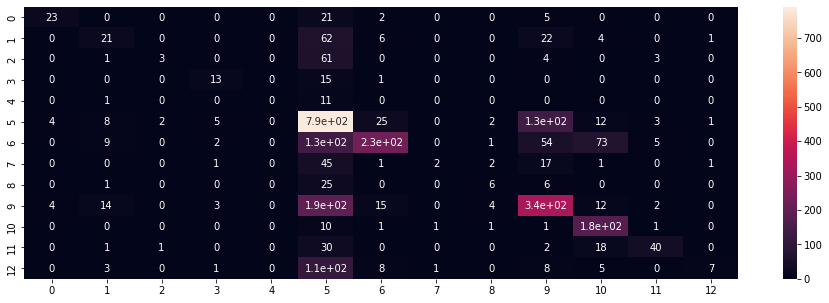

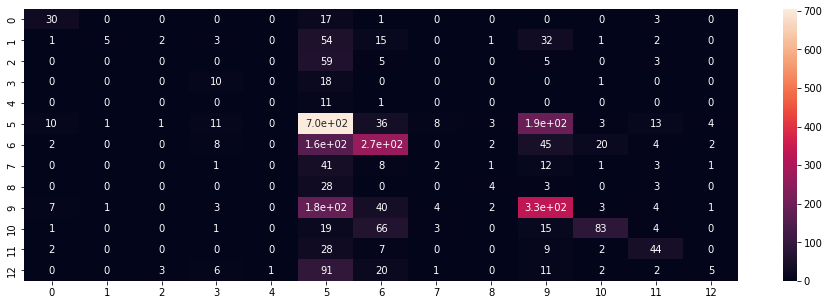

In [29]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader

import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model_to_use = ["bert-base-uncased",
                "sentence-transformers/all-MiniLM-L6-v2",
                ]

# "sentence-transformers/all-mpnet-base-v2"
# "nlpaueb/legal-bert-base-uncased"
# "sentence-transformers/bert-base-nli-cls-token",
# "sentence-transformers/bert-base-nli-max-tokens"

pool_funcs = ['mean']

for model_name in model_to_use:

    # if model_name != "nlpaueb/legal-bert-base-uncased":
    #   continue

    #HYPERPARAMETERS
    
    if(model_name != "sentence-transformers/all-MiniLM-L6-v2"):
        in_dim = 768
        

    else:
        in_dim = 384

        # if(model_name == "sentence-transformers/bert-base-nli-cls-token"):
        #     pool_funcs = ['cls']
        # elif(model_name == "sentence-transformers/bert-base-nli-max-tokens"):
        #     pool_funcs = ['max']

    # print(in_dim)
    hidd_dim = 300
    dropout_p = 0.4
    lr = 0.01
    batch_size = 256
    NUM_CLASSES = 13
    EPOCHS = 3

    for pool_type in pool_funcs:


        print("------------------------------------------------")
        print("------------------------------------------------")


        print(model_name)
        print(pool_type)

        print("------------------------------------------------")
        print("------------------------------------------------")



        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)


        # Instantiating the model class

        classification_model = Model(in_dim,hidd_dim,dropout_p,NUM_CLASSES)
        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        classification_model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(classification_model.parameters(), lr=lr)

        dataset = Corpus(X_train, Y_train)
        DL_DS = DataLoader(dataset, batch_size = batch_size, shuffle=True)
        classification_model.train()



        #training begins

        for epoch in range(EPOCHS):
            curr_loss = 0
            for idx, (x,y) in enumerate(DL_DS):
                optimizer.zero_grad()
                # x = enco(x)
                # print(x)
                y=y.to(device)
                label = classification_model(x,pool_type)
                # label.to(device)
                loss = criterion(label, y)
                loss.backward()
                optimizer.step()
                print(loss.item())
                curr_loss+=loss.item()
            print(f"Epoch -> {epoch} Loss -> {curr_loss}")




        with open(f"model_file_{model_name.split('/')[-1]}_{pool_type}", "wb") as f:
            torch.save(classification_model, f)


        
        y_pred_list = []
        with torch.no_grad():
            classification_model.eval()
            for idx in range(len(X_test)):
                x = X_test[idx]
                y_test_pred = classification_model(x,pool_type)
                _, y_pred_tags = torch.max(y_test_pred, dim = 1)
                y_pred_list.append(y_pred_tags.cpu().numpy())

            y_pred_list = [a.squeeze().tolist() for a in y_pred_list]




        
        plt.figure(figsize = (16,5))
        confusion_matrix_df = pd.DataFrame(confusion_matrix(Y_test, y_pred_list)).rename(columns=label_to_num_dict, index=label_to_num_dict)

        sns.heatmap(confusion_matrix_df, annot=True)
        plt.savefig(f"snsplot_{model_name.split('/')[-1]}_{pool_type}.png")


        print(classification_report(Y_test, y_pred_list))






        

        # tokenizer.to(device)